In [7]:
%matplotlib inline
import numpy as np
import scipy as sp
from utils import functions_2D as F2D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use(r'utils/mplstyle')

In [2]:
# nice colours to use

colorsBlue = ['#b3e5fc', '#0091ea']
colorsRed = ['#f18e86', '#e83b47']
colorsYellow = ['#fb9d32', '#fec787']
colorsPurple = ['#d69bc5' ,'#a8509f']
colorsGreyOrange = ['#c3c3c3', '#f8a834']
colors = [colorsBlue, colorsRed, colorsYellow, colorsPurple, colorsGreyOrange]

In [3]:
# generate a random 2D disk and check the shape is concave

seed = 219
std = 0.08
num_modes = 8 # the sum over modes runs from 2 to num_modes + 2

# r is a function r(order, θ)
# where order is the order of differentiation, 
# and φ is the polar angle of the contact point
r, A = F2D.get_r(seed, num_modes = num_modes, std = std)

# test whether the realisation is convex
# if the shape is concave, this prints a message
# test_r returns True/False
convex = F2D.test_r(r) 

critical ramp angle is 0.0746 rad


<IPython.core.display.Javascript object>


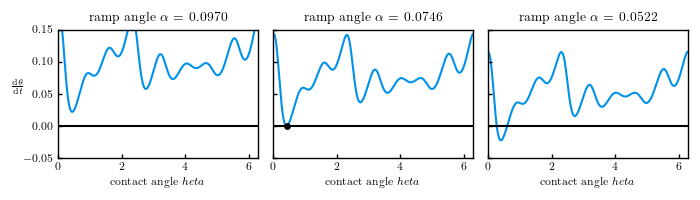

In [4]:
# plot the instantaneous angular velocity around the critical ramp angle

THETA = np.linspace(0, 2 * np.pi, 1000)
r0 = r(0, THETA)
r1 = r(1, THETA)
q = (r1 / r0)
Q = max(q)
p = THETA[np.argmax(q)]
a = np.arctan(Q)
print('critical ramp angle is {0:.4f} rad'.format(a))

fig, axes = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (7, 2))

for i in range(3):
    _a = a * (1.3 - i * 0.3) # plot dφ/dt at three ramp angles near criticality
    axes[i].plot(THETA[:-1], 1 / F2D.dtdθ(THETA[:-1], r, _a), color = colors[0][1], zorder = -1)
    axes[i].axhline(0, color = 'black')
    axes[i].set_ylim(-0.05, 0.15)
    axes[i].set_xlim(0, np.pi * 2)
    axes[i].set_title(r'ramp angle $\alpha$ = {0:.4f}'.format(_a))
    axes[i].set_xlabel('contact angle $\theta$')
# this is the point where dpdt = 0
axes[1].scatter([p], [0], s = 15, color = 'black')

axes[0].set_ylabel(r'$\frac{\dd\theta}{\dd t}$', rotation = 0)

plt.tight_layout()
plt.savefig('2DPlots/overdamped_illustration.pdf')

In [5]:
# compute 2π/T via direct integration of dt/dφ over φ

invTs = [] # 2π/T from direct integration
invTs2 = [] # 2π/T from scaling law near criticality
Qs = []
alphaInds = []
alphas = np.linspace(0, 0.2, 200)

std = 0.08
num_modes = 8

for i in range(10):
    print('computing for seed {0}'.format(i))
    _invT = []
    _invT2 = []

    _r, _A = F2D.get_r(i, num_modes = num_modes, std = std)
    
    if F2D.test_r(_r):
        _r0 = _r(0, THETA)
        _r1 = _r(1, THETA)

        _q = (_r1 / _r0)
        _Q = max(_q)
        _p = THETA[np.argmax(_q)]
        Qs.append(_Q)
        alphaStar = np.arctan(_Q)

        _r0 = _r(0, _p)
        _r1 = _r(1, _p)
        _r2 = _r(2, _p)
        _r3 = _r(3, _p)

        _Q2 = (2 * _r1 ** 3 - 3 * _r0 * _r1 * _r2 + _r0 ** 2 * _r3)/_r0 ** 3
        TStar = np.pi / np.sqrt(- _Q2)
        
        # to see the transition more clearly, we add two evaluation points around the critical angle
        alphaInd = np.append(alphas, [alphaStar + 1e-4, alphaStar - 1e-4])
        alphaInd = np.sort(alphaInd)

        for a in alphaInd:
            if np.tan(a) > _Q:
                res = sp.integrate.quad(F2D.dtdθ, 0, 2 * np.pi, args = (_r, a))
                _invT.append(1 / res[0])
                
                _da = a - alphaStar
                _invT2.append(1 / (TStar / np.sqrt(_da)))
            else:
                _invT.append(0)
                _invT2.append(0)
        invTs.append(_invT)
        invTs2.append(_invT2)
        alphaInds.append(alphaInd)

computing for seed 0
computing for seed 1
computing for seed 2
computing for seed 3
computing for seed 4
computing for seed 5
computing for seed 6
computing for seed 7
computing for seed 8
computing for seed 9


<IPython.core.display.Javascript object>


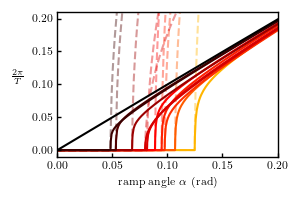

In [6]:
plt.figure(figsize = (3, 2))

# assign colour based on critical ramp angle
maxQ = np.max(Qs) + 0.05
minQ = np.min(Qs) - 0.01
def colorQ(_Q):
    return cm.hot((_Q - minQ) / (maxQ - minQ))

for i in range(len(invTs)):
    plt.plot(alphaInds[i], 2 * np.pi * np.array(invTs[i]), color = colorQ(Qs[i]), zorder = -Qs[i], alpha = 1)
    plt.plot(alphaInds[i], 2 * np.pi * np.array(invTs2[i]), color = colorQ(Qs[i]), zorder = -Qs[i], alpha = 0.4, linestyle = 'dashed')
    
plt.plot(alphas, np.sin(alphas), color = 'black')

plt.xlabel(r'ramp angle $\alpha$ (rad)')
plt.ylabel(r'$\frac{2\pi}{T}$', rotation = 0, labelpad = 10)
plt.ylim(-0.010, 0.21)
plt.xlim(0, 0.2)
plt.tight_layout()
plt.savefig('2DPlots/overdamped_transition.pdf')